# Balanced Cell Type Alignment

In [2]:
import pickle
import scanpy as sc
rna = pickle.load(open('./data/PBMC/rna_50pca_50topics.pkl', 'rb'))
atac = pickle.load(open('./data/PBMC/atac_50pca_50topics.pkl', 'rb'))
adata = sc.read_h5ad('./data/PBMC/adata.h5ad')

In [3]:
import pandas as pd
atac.columns = ["Region {0}".format(i + 1) for i in range(50)]
rna.columns = ["Gene {0}".format(i + 1) for i in range(50)]
rna.shape, atac.shape

((2407, 50), (2407, 50))

In [4]:
from scotplus.solvers import SinkhornSolver
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
ctypes = adata.obs['celltype']
ctypes = pd.Series(ctypes).loc[atac.index]
ctypes

CCAAGTTAGTAACCAC-1      CD14+ Monocytes
GTGCTTACAGTAATAG-1      CD14+ Monocytes
AGTCTTGCACAAAGAC-1    FCGR3A+ Monocytes
CTTTATGGTAAGCACC-1          CD4 T cells
CAATCGCCACTTCACT-1          CD4 T cells
                            ...        
CCGGTAGGTCGTTACT-1          CD4 T cells
CTAAATGTCTATTGTC-1          CD4 T cells
CCGCACACACTTCACT-1      CD14+ Monocytes
AATGCAACACCACAAC-1          CD4 T cells
CAAGGTTTCCCTGACT-1          CD4 T cells
Name: celltype, Length: 2407, dtype: category
Categories (7, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells']

In [6]:
rna = pd.concat((rna, ctypes), axis=1)
atac = pd.concat((atac, ctypes), axis=1)

In [7]:
atac_mtx = atac.iloc[:, :-1]
rna_mtx = rna.iloc[:, :-1]

In [8]:
rna_mtx=normalize(rna_mtx).astype('float64')
atac_mtx=normalize(atac_mtx)

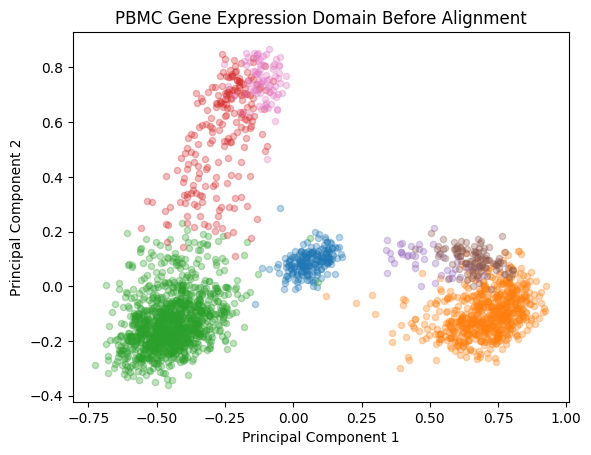

In [9]:
import numpy as np

# Sample label array (replace with your own label array)
label_array = np.array(rna['celltype'].to_list())

# Get unique labels
unique_labels = np.unique(label_array)
pca=PCA(n_components=2)
Xrna_2Dpca=pca.fit_transform(rna_mtx)
# Plot PCA-transformed data with labels
plt.figure()

# Plot each unique label separately
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Xrna_2Dpca[mask, 0], Xrna_2Dpca[mask, 1], s=20, alpha =0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

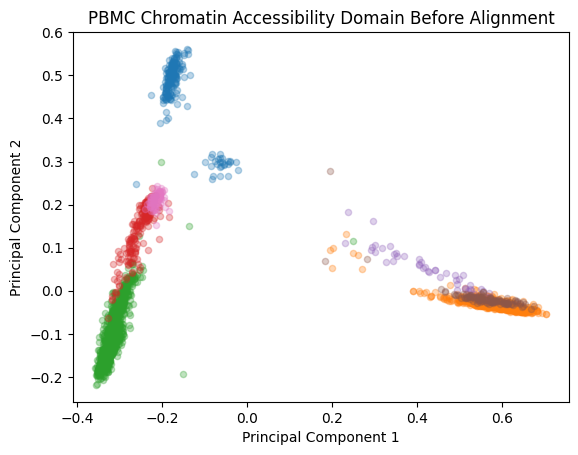

In [10]:
import numpy as np

# Sample label array (replace with your own label array)
label_array = np.array(rna['celltype'].to_list())

# Get unique labels
unique_labels = np.unique(label_array)
pca=PCA(n_components=2)
Yatac_2Dpca=pca.fit_transform(atac_mtx)
# Plot PCA-transformed data with labels
plt.figure()

# Plot each unique label separately
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yatac_2Dpca[mask, 0], Yatac_2Dpca[mask, 1], s=20, alpha =0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [11]:
from scotplus.utils.alignment import compute_graph_distances

Drna = compute_graph_distances(rna_mtx, n_neighbors=25, mode='connectivity')
Datac =compute_graph_distances(atac_mtx, n_neighbors=25, mode='connectivity')
agw_class = SinkhornSolver(tol_uot=1e-3)
pi_samp,_,pi_feat = agw_class.agw(torch.from_numpy(rna_mtx).to(device), torch.from_numpy(atac_mtx).to(device), torch.from_numpy(Drna).to(device), torch.from_numpy(Datac).to(device), eps = 1e-1, verbose = True, log=False)

BCD Iteration 1 - Loss: 7.988310, 8.291222
BCD Iteration 2 - Loss: 7.988713, 8.292141
BCD Iteration 3 - Loss: 7.988976, 8.292407
BCD Iteration 4 - Loss: 7.989129, 8.292559
BCD Iteration 5 - Loss: 7.989210, 8.292640
BCD Iteration 6 - Loss: 7.989252, 8.292683
BCD Iteration 7 - Loss: 7.989275, 8.292705
BCD Iteration 8 - Loss: 7.989286, 8.292716
BCD Iteration 9 - Loss: 7.989290, 8.292720
BCD Iteration 10 - Loss: 7.989291, 8.292722
BCD Iteration 11 - Loss: 7.989290, 8.292720
BCD Iteration 12 - Loss: 7.989288, 8.292718
BCD Iteration 13 - Loss: 7.989285, 8.292715
BCD Iteration 14 - Loss: 7.989282, 8.292711
BCD Iteration 15 - Loss: 7.989278, 8.292708


In [12]:
from scotplus.utils.alignment import get_barycentre
aligned_atac = get_barycentre(rna_mtx, np.transpose(pi_samp))
rna_mtx.shape, aligned_atac.shape

((2407, 50), torch.Size([2407, 50]))

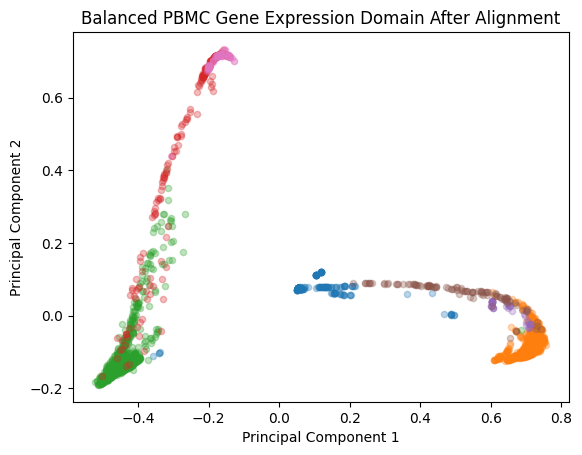

In [14]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
# run PC jointly:
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=pca.fit_transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['celltype'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_pc = np.concatenate((Xrna_integrated_pc,Yatac_subsamp_integrated_pc), axis=0)
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yatac_subsamp_integrated_pc[mask, 0], Yatac_subsamp_integrated_pc[mask, 1], s=20,alpha =0.3, label = label)
    
    
plt.title('Balanced PBMC Gene Expression Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

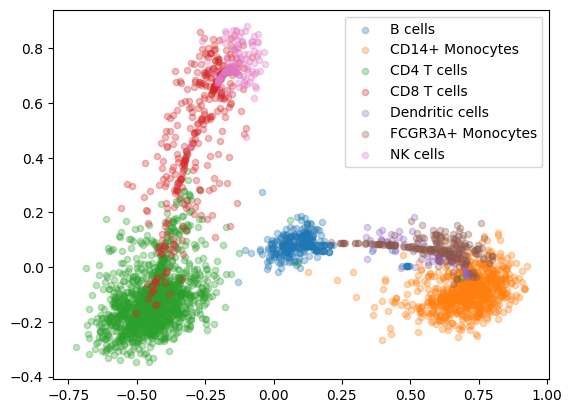

In [14]:
rna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
# run PC jointly:
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=pca.fit_transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['celltype'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_pc = np.concatenate((Xrna_integrated_pc,Yatac_subsamp_integrated_pc), axis=0)
for label in unique_labels:
    mask = (concat_labels == label)
    plt.scatter(concat_pc[mask, 0], concat_pc[mask, 1], s=20, alpha =0.3, label = label)
plt.legend(loc='best', shadow=False)

/users/cbaker20/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/cbaker20/.conda/envs/scotplus/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


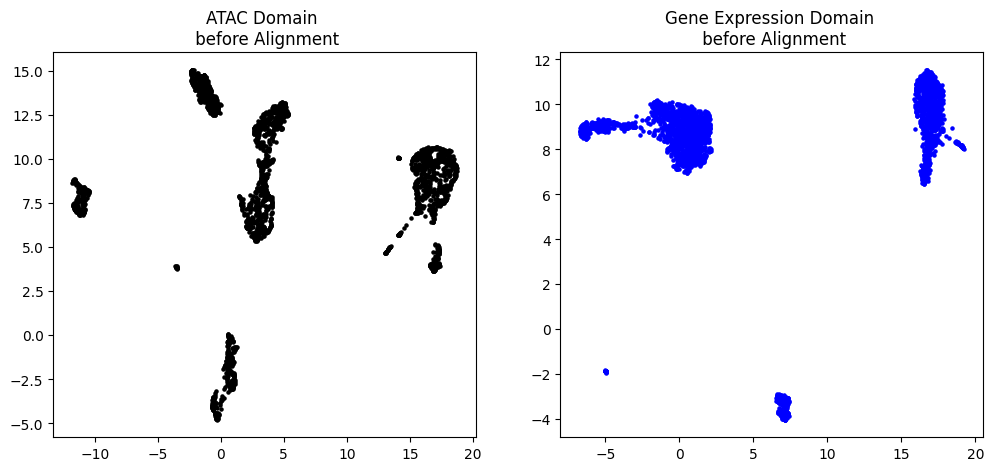

In [15]:
import umap
um = umap.UMAP(random_state=0)

originalX_um=um.fit_transform(atac_mtx)
originaly_um=um.fit_transform(rna_mtx)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12, 5))
ax1.scatter(originalX_um[:,0], originalX_um[:,1], c="k", s=5)
ax1.set_title("ATAC Domain \n before Alignment")
ax2.scatter(originaly_um[:,0], originaly_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

In [16]:
Xy_um=um.fit_transform(np.concatenate((aligned_atac.numpy(), rna_mtx), axis=0))

X_um=Xy_um[0:2047,]
y_um=Xy_um[2047:,]

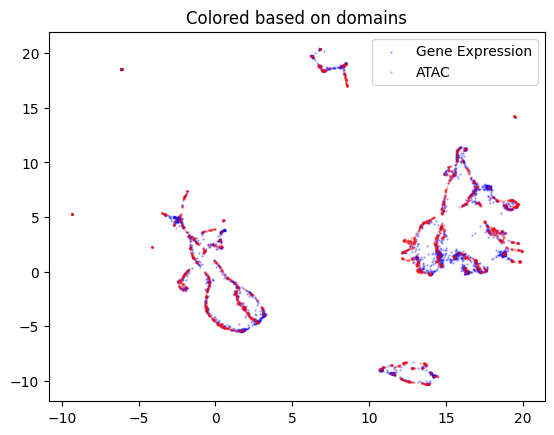

In [17]:
plt.scatter(y_um[:,0], y_um[:,1], c="b", alpha=0.3, s=0.5, label="Gene Expression")
plt.scatter(X_um[:,0], X_um[:,1], c="r", alpha=0.3, s=0.5, label="ATAC")
plt.legend()
plt.title("Colored based on domains")
plt.show()

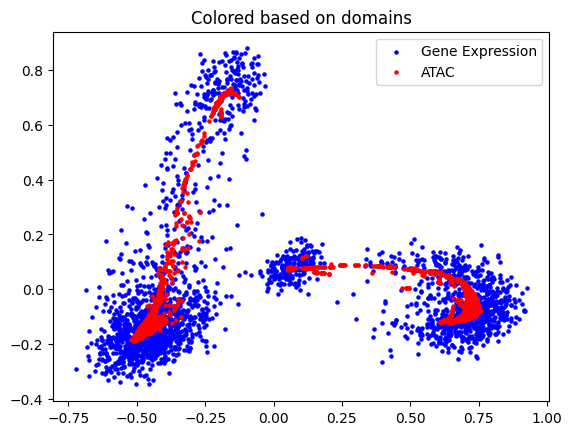

In [18]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((aligned_atac.numpy(), rna_mtx), axis=0))
X_pca=Xy_pca[0:2047,]
y_pca=Xy_pca[2047:,]

# Plot aligned domains, samples colored by domain identity:
plt.scatter(y_pca[:,0], y_pca[:,1], c="b", s=5, label="Gene Expression")
plt.scatter(X_pca[:,0], X_pca[:,1], c="r", s=5, label="ATAC")
plt.legend()
plt.title("Colored based on domains")
plt.show()

Average FOSCTTM score for this alignment with X onto Y is: 0.1319310261943811


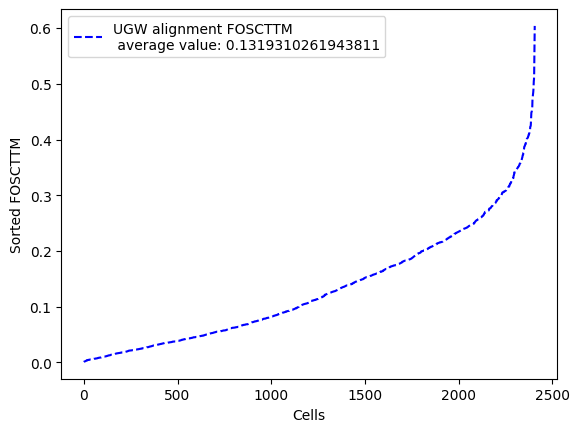

In [20]:
from scotplus.utils.alignment import calc_domainAveraged_FOSCTTM
fracs = calc_domainAveraged_FOSCTTM(aligned_atac.numpy(), rna_mtx)
print("Average FOSCTTM score for this alignment with X onto Y is:", np.mean(fracs))
legend_label="UGW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

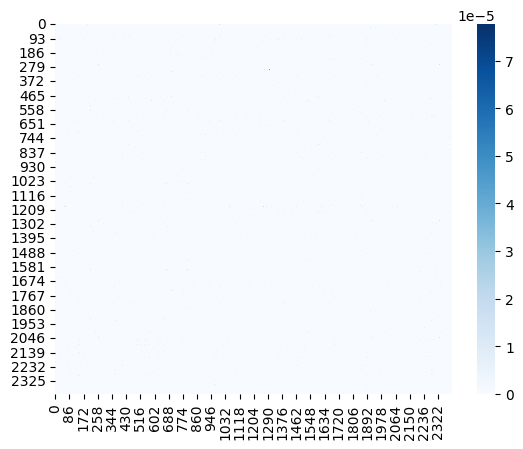

In [21]:
import seaborn as sns
sns.heatmap(pi_samp, cmap='Blues')
plt.show()